      Demand  Forecast     Error
0   5.740646       NaN       NaN
1   1.841978  5.740646 -3.898668
2  -2.237030  3.401445 -5.638475
3   3.529698  0.018360  3.511338
4   1.081589  2.125163 -1.043573
..       ...       ...       ...
60  3.691240  0.786024  2.905217
61       NaN  2.529153       NaN
62       NaN  2.529153       NaN
63       NaN  2.529153       NaN
64       NaN  2.529153       NaN

[65 rows x 3 columns]
MAE: 1.89
RMSE: 3.55


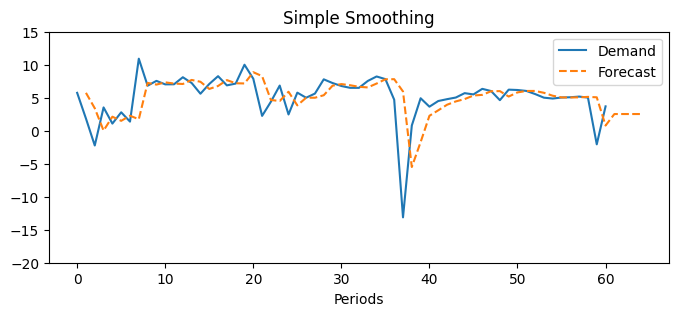

In [3]:
import numpy as np
import pandas as pd

def simple_exp_smooth(d, extra_periods=1, alpha=0.6):  
    d = np.array(d)  # Transform the input into a numpy array  
    cols = len(d)  # Historical period length  
    d = np.append(d, [np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
    f = np.full(cols+extra_periods, np.nan)  # Forecast array  
    f[1] = d[0]  # initialization of first forecast  
    # Create all the t+1 forecasts until end of historical period  
    for t in range(2, cols+1):  
        f[t] = alpha*d[t-1] + (1-alpha)*f[t-1]  
    f[cols+1:] = f[t]  # Forecast for all extra periods  
    df = pd.DataFrame.from_dict({"Demand": d, "Forecast": f, "Error": d-f})
    return df

data = pd.read_csv("/Users/farrelmanazilin/Downloads/data/uas.csv")
df = simple_exp_smooth(data["gdp"], extra_periods=4)
print(df)
df.index.name = "Periods"
df[["Demand","Forecast"]].plot(figsize=(8,3),title="Simple Smoothing",ylim=(-20,15),style=["-","--"])
MAE = df["Error"].abs().mean()  
print("MAE:",round(MAE,2)) 
RMSE = np.sqrt((df["Error"]**2).mean())
print("RMSE:",round(RMSE,2))


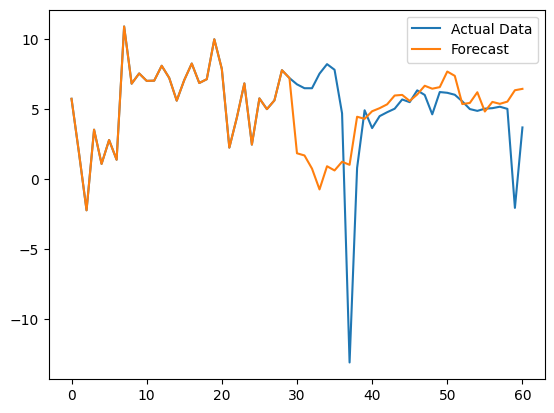

MAE: 2.7224186332609595
RMSE: 4.297504317209722


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data
data = pd.read_csv("/Users/farrelmanazilin/Downloads/data/uas.csv")
df = data["gdp"]
n = len(df)

# Split data into training and testing sets
train_size = int(0.5 * n)
train_data = df[:train_size]
test_data = df[train_size:]

# Holt-Winters Method without Seasonality
def holt_winters(data, alpha, beta, iterations):
    level = data[0]
    trend = data[1] - data[0]
    forecast = []
    
    for i in range(len(data) + iterations):
        if i >= len(data):
            forecast.append(level + trend * (i - len(data) + 1))
        else:
            forecast.append(level + trend)
            level = alpha * data[i] + (1 - alpha) * (level + trend)
            trend = beta * (level - data[i]) + (1 - beta) * trend
    
    return forecast

# Set Holt-Winters parameters
alpha = 0.6
beta = 0.6
iterations = len(test_data)

# Apply Holt-Winters method to forecast
forecast = holt_winters(train_data, alpha, beta, iterations)

# Extend train_data with NaN values for the forecast period
extended_train_data = pd.concat([train_data, pd.Series(np.nan, index=test_data.index)])

# Slice the forecast array for the forecast period
forecast_sliced = forecast[:len(test_data)]

# Replace NaN values in extended_train_data with forecast values
extended_train_data.loc[test_data.index] = forecast_sliced

# Plot actual data and forecast
plt.plot(df, label='Actual Data')
plt.plot(extended_train_data, label='Forecast')
plt.legend()
plt.show()

# Calculate MAE and RMSE
mae = mean_absolute_error(test_data, forecast_sliced)
rmse = np.sqrt(mean_squared_error(test_data, forecast_sliced))

# Print MAE and RMSE
print('MAE:', mae)
print('RMSE:', rmse)
